Re-implementing NeRF paper in a single notebook.

In [1]:
import os
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import imageio
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

#### Key Concepts

<div style="display: flex; justify-content: center; gap: 20px;">
  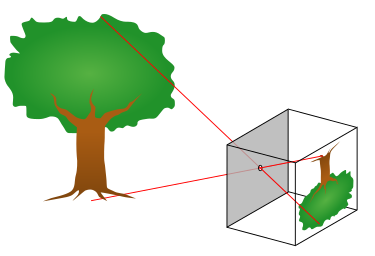
  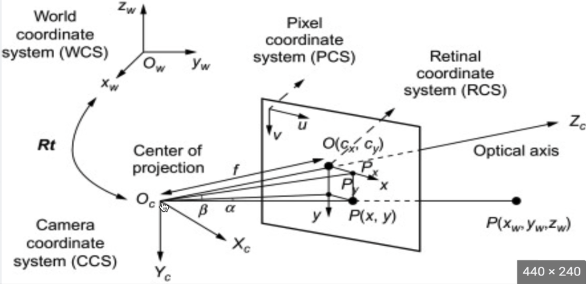
</div>

Some concepts regarding NeRF, such as pinhole camera model, ray tracing, 3D rendering, differentiable rendering, optimization, and rotation matrix. 

The concept of pinhole camera and <a href="https://www.udemy.com/course/neural-radiance-fields-nerf/learn/lecture/35524410#overview">backward ray tracing</a> is that we can replicate the effect by sending **rays from each pixel of the image** (camera) to the scene through the pinhole until the ray hits a light source. 

The right figure reprecents the concept, where $(u,v)$ represent the pixel coordidnate system for the location. The parameters are as following for the camera:
- $H$, $W$ are the resolution of the image.
- $f$ is the distance between the pinhole and the plan where the image is formed at (focal length).
- $u$, $v$ coordinate system representation where $u$ is the change on the x-axis and $v$ is the change on y-axis.

Rays are represented by a vector that can be represented using an origin and a direction. We used the representation $H \times W$ to represent all of the image pixels togather, with 3D view.

When we are computing the directions of the rays in $dirs$ variable, we are starting from the (0,0) coordinates, and going towards the pinhole, thus for example, for the x-axis, we divide the $W$ by 2, then subtract it from the $u$ to reach the center of the image, and thus be centered toward the projection (pinhole). This will result in the center coordinate having a coordinate value of 0 exactly at the center for the x-coordinate.

```python
# debug
u[0][W//2] - W / 2 # where we experiment on the first row of u, and obtain the center coordinate using w//2, and subtract half of the image width, to get the center coordinate value of 0.0
```

Another note regarding the directions is that y-axis is pointing downwards, but we want to use the convention of y pointing upwards, thus we added a negative sign on the y-axis when we were computing the $dirs$ variable. This is similar to the z-axis which is the focal length, that we want it to point from the image towards the pinhole (camera coordinate system), thus we invert it using the negative sign.

In [2]:
# Numpy implementation
H = 400  # Height
W = 400  # Width
f = 1200 # focal length, distance between the pinhole of the box and the plane where the image will be formed on 

# Creating rays, we have two components, each image pixel will have a ray, thus H*W, and 3 for 3D
rays_o = np.zeros((H*W, 3)) # rays origin
rays_d = np.zeros((H*W, 3)) # rays direction

# Computing the coordinates of the pixels
u = np.arange(W)
v = np.arange(H)

# Creating a grid with all possible pixel coord values
# both u and v shapes will transform to H, W, this is because in image processing conventions, it’s always (H, W, …)
u, v = np.meshgrid(u, v)

# Computing the direction that is going from the image to the pinhole (center)
# final shape will be (H, W, 3)
dirs = np.stack(( u - W / 2,           # x-axis (horizontal shift from image center)
                 -(v - H / 2),         # y-axis (vertical shift, flipped so y points up)
                 -np.ones_like(u)*f    # z-axis (into the camera from the image)
                ), axis=-1)            # stack along the last axis, thus stack all three on top of each other, and last axis will be 3

# rays_d.shape is (H, W, 3)
rays_d = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True) # normalize along the last axis dimension
rays_d = rays_d.reshape(-1, 3) # reshape to (H*W, 3)

print(rays_o.shape, u.shape, v.shape, rays_d.shape, u.shape, v.shape, dirs.shape)

(160000, 3) (400, 400) (400, 400) (160000, 3) (400, 400) (400, 400) (400, 400, 3)


For plotting the rays, we create a function called `plot_rays` that takes the origin, direction, and time $t$ that we want to plot at. Note that matplotlib convension is opposite to what we implemented (that z-axis points positive upwards). Because we are shooting rays in the code in -z direction, matplotlib is showing downwards which is expected.

In [3]:
def plot_rays(o, d, t_max, step=1, sample_points=False):
    """
    Visualize rays and (optionally) sampled points: r(t) = o + t*d
    
    Args:
        o (np.ndarray): shape (N, 3), ray origins.
        d (np.ndarray): shape (N, 3), ray directions (unit).
        t_max (float): maximum distance along ray.
        step (int): subsampling step (>=1).
        sample_points (bool): whether to scatter sample points along each ray.
    """
    assert step >= 1, "`step` must be >= 1"

    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(projection='3d')

    # Endpoints at distance t_max
    pt1 = o
    pt2 = o + t_max * d

    for p1, p2 in zip(pt1[::step], pt2[::step]):
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], alpha=0.4)
        
        if sample_points:
            t_vals = np.linspace(0, t_max, num=5)
            pts = p1 + t_vals[:, None] * (p2 - p1)  # shape (5, 3)
            ax.scatter(pts[:,0], pts[:,1], pts[:,2], c="orange", s=5)

        
    # ax.scatter(0,0,0, c="red", s=100, label="Camera origin (pinhole)")
    ax.scatter(o[0,0], o[0,1], o[0,2], c="red", s=100, label="Camera Origin") # Plot the actual camera origin

    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    ax.set_title("Rays from a Camera Origin")
    ax.legend()
    # ax.view_init(elev=20, azim=-60)

    plt.show()

In [4]:
rays_o[::400].shape

(400, 3)

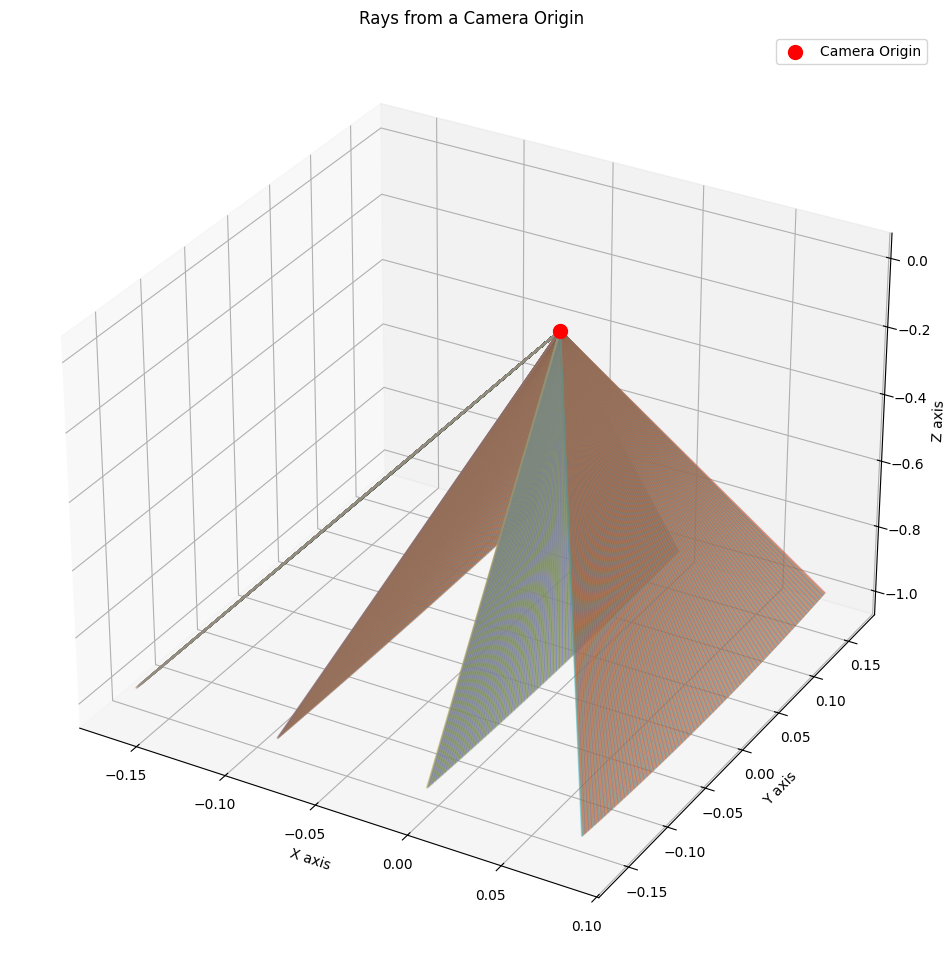

In [5]:
plot_rays(rays_o, rays_d, t_max=1, step=100, sample_points=False)
# plot_rays(rays_o, rays_d, t_max=1, step=590, sample_points=False) # shows the rays better

The next part of the simulator assigns colors to the rays, thus we are able to create an image. The code below creates a simple scene that is represented by a sphere. To assign a color to each ray, we need to know the intersection of the rays with the sphere. The sphere formula can be represented as $(x - xc)^2 + (y - yc)^2 + (z - zc)^2 = r^2$ where $x$, $y$, $z$ are the intersection of the rays with the sphere, therefor we can re-write it as $(ox + t*dx - xc)^2 + (oy + t*dy - yc)^2 + (oz + t*dz - zc)^2 = r^2$. We need to solve this equation to find the time t which the ray hits the sphere. If there is no solution, there won't be t.

First, we will solve the equation $at^{2} + bt + c = 0$, and then solve for $pho = b^{2} - 4 \times a \times c$ to find if there is a solution or not to find $t1$ and $t2$ intersections of the sphere (rays will intersect twice).

In [6]:
class Sphere():
    def __init__(self, p, r, c):
        self.p = p # position
        self.r = r # radius
        self.c = c # color

    def intersect(self, o, d):
        a = d[:, 0]**2 + d[:, 1]**2 + d[:, 2]**2
        b = 2 * ((d[:, 0] * (o[:, 0] - self.p[0])) + (d[:, 1] * (o[:, 1] - self.p[1])) + (d[:, 2] * (o[:, 2] - self.p[2])))
        c = (o[:, 0] - self.p[0])**2 + (o[:, 1] - self.p[1])**2 + (o[:, 2] - self.p[2])**2 - self.r**2

        pho = b**2 - 4* a * c

        condition = pho >= 0

        num_rays = o.shape[0]
        colors = np.zeros((num_rays, 3))
        colors[condition] = self.c # else will be 0
        
        return colors

In [7]:
s = Sphere(np.array([0., 0., -1.]), .1, np.array([1., 0., 0.,]))
c = s.intersect(rays_o, rays_d)
c.sum(), c.shape

(np.float64(45709.0), (160000, 3))

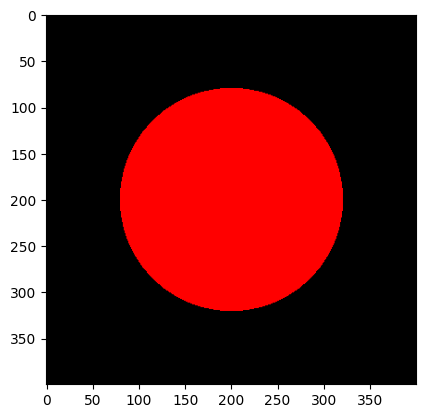

In [8]:
img = c.reshape(H, W, 3)
plt.imshow(img)

Some common ways to represent a scene is using trimesh or volumetric rendering. **NeRF approach utilizes volumetric rendering** rather than trimesh because trimesh is very difficult to be differentiable and to optimize the triangles, thus NeRF relies on volumetric rendering which is easier to optimize. Now, there are new papers that utilizes trimesh. 

In NeRF, each point in space can be represented by both a density and color. Density tells object availability in the space, where an empty space has density equals to 0.

How it works is that a ray is shot towards a scene, where point samples are drawn from the rays. Each point has a color and density, thus if 100 points are used, we will have 100 colors and densities. The ray in the official paper is represented as $r(t) = o + td$ where $t$ is time. The integral in the color formula of the volume rendering is computed from $t_{n}$ to $t_{f}$. We will re-write the `Sphere` class following the volume rendering equation in NeRF paper.

In [9]:
# This is a dummy example to return the colors and densities and will be replaced with the NerF model
class Sphere():
    def __init__(self, p, r, c):
        self.p = p # position
        self.r = r # radius
        self.c = c # color

    def intersect(self, x):
        """
        :param x: points [batch_size, 3]
        """
        # x: position x, will have a density and color, need to make sure that the point x is inside the sphere
        # we minus - self.p[0]) to take into account the center of the sphere
        # (x-xc)^2 + (y-yc)^2 + (z-zc)^2 <= r^2
        condition = (x[:, 0] - self.p[0])** 2 + (x[:, 1] - self.p[1])** 2 + (x[:, 2] - self.p[2])** 2 <= self.r**2 
        
        num_rays = x.shape[0]
        colors = torch.zeros((num_rays, 3))
        density = torch.zeros((num_rays, 1))
        
        colors[condition] = self.c # else will be 0
        density[condition] = 10
        
        return colors, density

In [10]:
def compute_accumulated_transmittance(beta):
    accumulated_transmittance = torch.cumprod(beta, 1)

    # Instead of this, we do the concat in the return
    # accumulated_transmittance[:, 1:] = accumulated_transmittance[:, :-1] # shift everything to the right
    # accumulated_transmittance[:, 0] = 1. #  because j starts from 1 in the sum inside the exp and exp of 0 = 1
    
    return torch.cat((torch.ones(accumulated_transmittance.shape[0], 1, device=accumulated_transmittance.device), 
                     accumulated_transmittance[:, :-1]), dim=1)
    
def rendering(model, rays_o, rays_d, tn, tf, nb_bins=100, device='cpu'):
    # rays_o, rays_d: rays info
    # tn, tf: integral limits
    # nb_bins: number of bins

    # integral equation here, or the equivelant eqn 3

    # time t between bins
    t = torch.linspace(tn, tf, nb_bins).to(device) # [nb_bins]
    
    # delta is the distance between adjacent samples, shape is [nb_bins]
    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10], device=device))) # t_{i+1} - t_{i}. Note that we concat an additional inf. item to match the shape of t

    # r(t) tells the position of the ray at time t    
    # rays_o.shape: [160000, 3] > [160000, 1, 3]
    # t.shape:      [nb_bins] > [1, nb_bins, 1]
    # rays_d.shape: [160000, 3] > [160000, 1, 3]
    # x.shape:      [160000, 100, 3] = [nb_rays, nb_bins, 3] because for each ray there has to be a number of bins and 3d points
    x = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1)

    # Query the color and density for each of the points
    # reshaping the points to match [batch_size, 3]
    # batch size is the total number of points on all of the rays
    colors, density = model.intersect(x.reshape(-1, 3))

    # reshaping colors from [batch_size, 3] to [160000, 100, 3]
    # reshaping density from [batch_size, 1] to [160000, 100, 1]
    colors  = colors.reshape(x.shape[0], nb_bins, 3) 
    density = density.reshape(x.shape[0], nb_bins)

    # computing alpha term
    # reshaping delta from [nb_bins] to [1, nb_bins]
    # alpha.shape: [160000, 100]=[nb_rays, nb_bins]
    alpha = 1 - torch.exp(- density * delta.unsqueeze(0))

    # Computing the term T
    # T.shape: [nb_rays, nb_bins] 
    T = compute_accumulated_transmittance(1-alpha)
    
    # c.shape: [nb_rays,  3]
    c = (T.unsqueeze(-1) * alpha.unsqueeze(-1) * colors).sum(1)

    return c

In [11]:
model = Sphere(torch.tensor([0., 0., -1.]), 0.1, torch.tensor([1., 0., 0.,]))
px_colors = rendering(model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 0.8, 1.2)

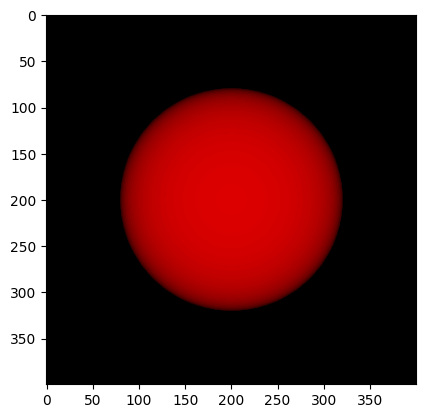

In [12]:
img =  px_colors.reshape(H, W, 3).cpu().numpy()
plt.imshow(img)

As we can now generate images, we need to have a differentiable renderer so that we can compute gradients on the gradient descent. We need to make sure that the gradient flow properly so that we can optimize some model parameters, for instance, the colors.

In [13]:
model = Sphere(torch.tensor([0., 0., -1.]), 0.1, torch.tensor([1., 0., 0.,]))
b = rendering(model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 0.8, 1.2)

# for instance, we want to optimize the colors
c_to_optimize = torch.tensor([0., 0., 0.,], requires_grad=True) # for instance, we start with black color
optimizer = torch.optim.SGD({c_to_optimize}, lr=1e-1)

tensor([0.0099, 0.0000, 0.0000], requires_grad=True)


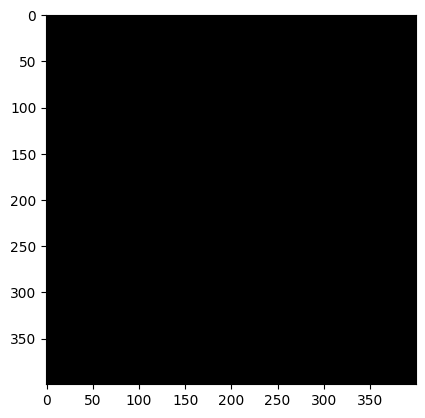

tensor([0.1034, 0.0000, 0.0000], requires_grad=True)


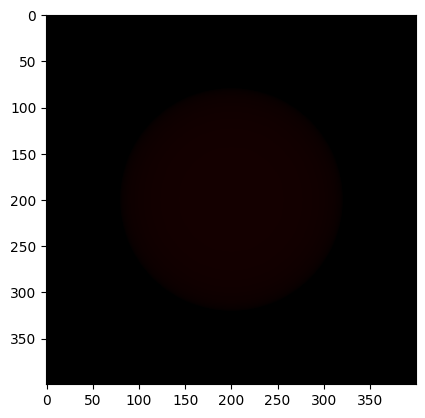

tensor([0.1881, 0.0000, 0.0000], requires_grad=True)


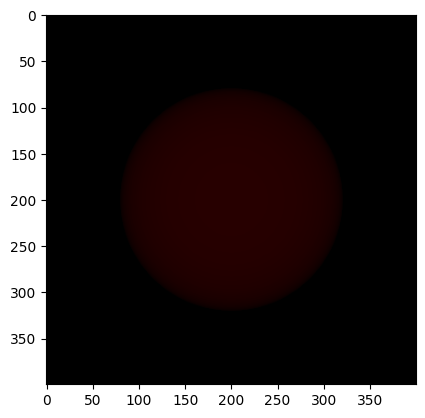

tensor([0.2648, 0.0000, 0.0000], requires_grad=True)


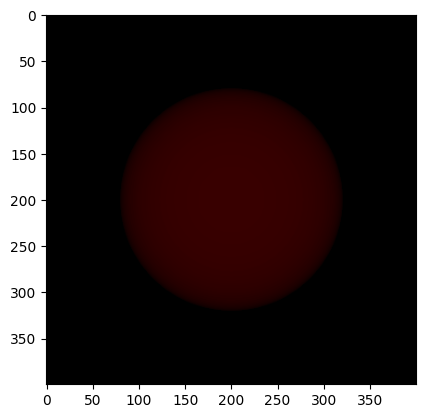

tensor([0.3342, 0.0000, 0.0000], requires_grad=True)


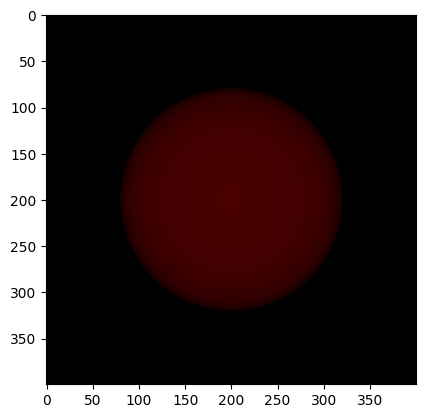

tensor([0.3971, 0.0000, 0.0000], requires_grad=True)


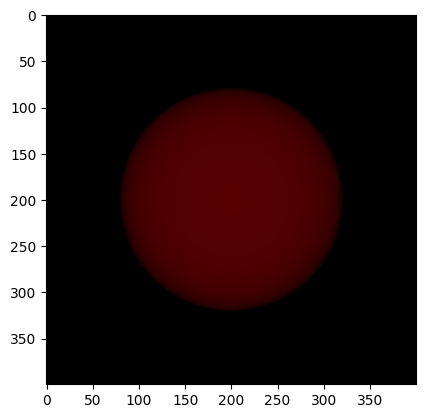

tensor([0.4541, 0.0000, 0.0000], requires_grad=True)


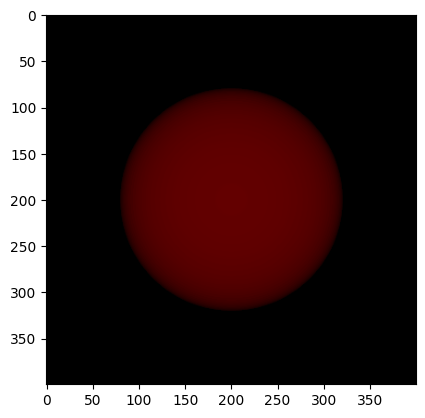

tensor([0.5056, 0.0000, 0.0000], requires_grad=True)


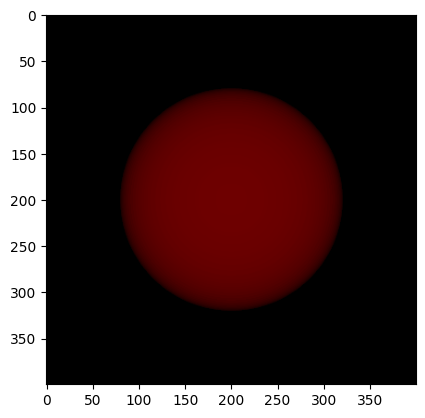

tensor([0.5523, 0.0000, 0.0000], requires_grad=True)


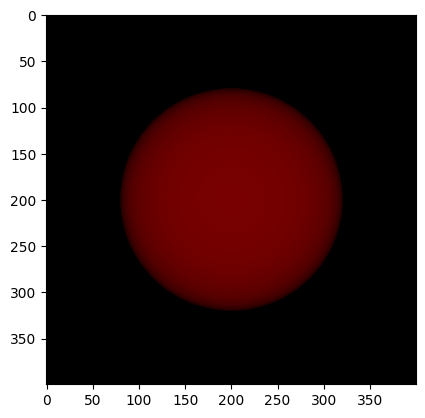

tensor([0.5946, 0.0000, 0.0000], requires_grad=True)


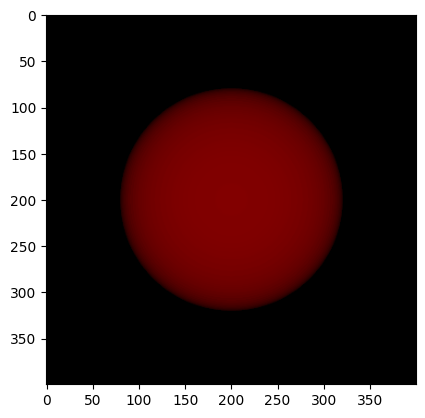

In [14]:
for epoch in range(100):
    model = Sphere(torch.tensor([0., 0., -1.]), 0.1, c_to_optimize)
    Ax = rendering(model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 0.8, 1.2)
    
    loss = ((Ax-b)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(c_to_optimize)
        img =  Ax.reshape(H, W, 3).detach().numpy()
        plt.imshow(img)
        plt.show()

So far the camera was from a fixed orientation, but we need to take into account complex structures from different angles, thus we should update the camera model to be able to view from any position or orientation. In the following cells, the `c2w` variable refers to `camera to world`, which is a **transformation matrix** that is used to transform the camera. It’s a rigid transform (rotation + translation), usually:

$$
c2w = 
\begin{bmatrix} 
R & T \\
0 & 1 
\end{bmatrix} =
\begin{bmatrix}
r_{11} & r_{12} & r_{13} & t_x \\
r_{21} & r_{22} & r_{23} & t_y \\
r_{31} & r_{32} & r_{33} & t_z \\
0 & 0 & 0 & 1
\end{bmatrix}
$$


where:
* R → 3×3 rotation matrix (camera orientation in the world)
* t → 3×1 translation vector (camera position in the world)

In [15]:
# An example of a camera to world rotation matrix
c2w1 = np.array([0.34303784370422363,
                 -0.8594792485237122,
                 0.3789729177951813,
                 3.7897279262542725,
                 0.9393215775489807,
                 0.3138796091079712,
                 -0.13839992880821228,
                 -1.3840025663375854,
                 0.0,
                 0.40345385670661926,
                 0.9150000214576721,
                 9.149999618530273,
                 0.0,
                 0.0,
                 0.0,
                 1.0])
c2w1 = c2w1.reshape((4, 4))

c2w2 = np.array([-0.7053813934326172,
                -0.5776947736740112,
                0.41073814034461975,
                4.1073899269104,
                0.7088279724121094,
                -0.5748858451843262,
                0.4087409973144531,
                4.087401390075684,
                0.0,
                0.5794609785079956,
                0.8149999976158142,
                8.149999618530273,
                0.0,
                0.0,
                0.0,
                1.0])
c2w2 = c2w2.reshape((4, 4))

In [16]:
c2w1

array([[ 0.34303784, -0.85947925,  0.37897292,  3.78972793],
       [ 0.93932158,  0.31387961, -0.13839993, -1.38400257],
       [ 0.        ,  0.40345386,  0.91500002,  9.14999962],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [17]:
# Camera position (translation) separated
c2w1[:3, 3]

array([ 3.78972793, -1.38400257,  9.14999962])

In [18]:
# rotation matrix separated
c2w1[:3, :3]

array([[ 0.34303784, -0.85947925,  0.37897292],
       [ 0.93932158,  0.31387961, -0.13839993],
       [ 0.        ,  0.40345386,  0.91500002]])

From the example matrix above, the camera position is represented using the last column of the matrix, that is for $t_{x}$, $t_{y}$, and $t_{z}$. The 3x3 matrix on the top left is called rotation matrix that is responsible for the camera orientation. We need this matrix to perform orientation as the camera coordinates (similar to robots concept) are different from the world coordinates.

Rotation around the X-axis
$$
R_x(\theta) =
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & \cos\theta & -\sin\theta & 0 \\
0 & \sin\theta & \cos\theta & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

Rotation around the Y-axis
$$
R_y(\theta) =
\begin{bmatrix}
\cos\theta & 0 & \sin\theta & 0 \\
0 & 1 & 0 & 0 \\
-\sin\theta & 0 & \cos\theta & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

Rotation around the Z-axis
$$
R_z(\theta) =
\begin{bmatrix}
\cos\theta & -\sin\theta & 0 & 0 \\
\sin\theta & \cos\theta & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

Previous code generates rays in the coordinate system of the camera, where each camera has it's own coordinate system that is different than the world coordinate system. **If we want to move the rays from the camera coordinate system to the world coordinate system, we apply the rotation matrix** because the rendering will usually happen in the world system. **This is easily done through matrix multiplication before the normalization step.**

In [19]:
# Numpy implementation
H = 400  # Height
W = 400  # Width
f = 1200 # focal length, distance between the pinhole of the box and the plane where the image will be formed on 

# Choose which transformation matrix
c2w = c2w2

# Creating rays, we have two components, each image pixel will have a ray, thus H*W, and 3 for 3D
rays_o = np.zeros((H*W, 3)) # rays origin
rays_d = np.zeros((H*W, 3)) # rays direction

# Computing the coordinates of the pixels
u = np.arange(W)
v = np.arange(H)

# Creating a grid with all possible pixel coord values
# both u and v shapes will transform to H, W, this is because in image processing conventions, it’s always (H, W, …)
u, v = np.meshgrid(u, v)

# Computing the direction that is going from the image to the pinhole (center)
# final shape will be (H, W, 3)
dirs = np.stack(( u - W / 2,           # x-axis (horizontal shift from image center)
                 -(v - H / 2),         # y-axis (vertical shift, flipped so y points up)
                 -np.ones_like(u)*f    # z-axis (into the camera from the image)
                ), axis=-1)            # stack along the last axis, thus stack all three on top of each other, and last axis will be 3

# Convert from camera coordinate system to world coordinate system using the rotation matrix of the transformation matrix (3x3).
dirs = (c2w[:3, :3] @ dirs[..., None])[..., 0]

# rays_d.shape is (H, W, 3)
rays_d = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True) # normalize along the last axis dimension
rays_d = rays_d.reshape(-1, 3) # reshape to (H*W, 3)

# Adding the translation (last column) to the rays origin 
rays_o += c2w[:3, 3]

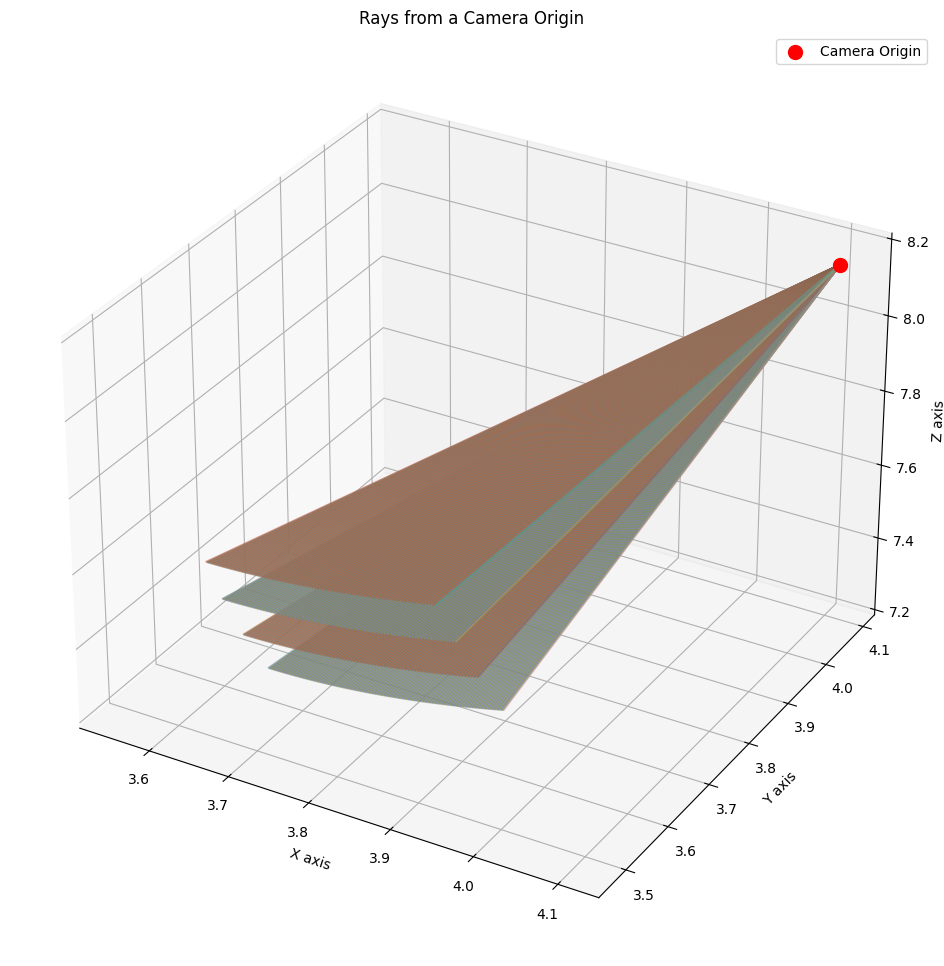

In [20]:
plot_rays(rays_o, rays_d, t_max=1, step=100, sample_points=False)

In [21]:
model = Sphere(torch.tensor([0., 0., 0.]), 1, torch.tensor([1., 0., 0.,]))
px_colors = rendering(model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 8, 12)

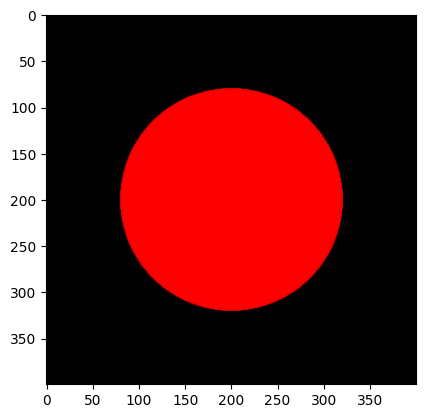

In [22]:
img = px_colors.reshape(H, W, 3)

plt.figure(dpi=100)
plt.imshow(img)

Updating the `Sphere` model to display two colors.

In [23]:
# This is a dummy example to return the colors and densities and will be replaced with the NerF model
class Sphere():
    def __init__(self, p, r, c):
        self.p = p # position
        self.r = r # radius
        self.c = c # color

    def intersect(self, x):
        """
        :param x: points [batch_size, 3]
        """
        # x: position x, will have a density and color, need to make sure that the point x is inside the sphere
        # we minus - self.p[0]) to take into account the center of the sphere
        # (x-xc)^2 + (y-yc)^2 + (z-zc)^2 <= r^2
        condition = (x[:, 0] - self.p[0])** 2 + (x[:, 1] - self.p[1])** 2 + (x[:, 2] - self.p[2])** 2 <= self.r**2 
        
        num_rays = x.shape[0]
        colors = torch.zeros((num_rays, 3))
        density = torch.zeros((num_rays, 1))
        
        colors[condition] = self.c # else will be 0
        density[condition] = 10

        # when x < 0, the color will be green now
        color_condition = x[:, 0] < 0
        tmp = colors[color_condition, 0].clone()
        colors[color_condition, 0] = colors[color_condition, 1].clone()
        colors[color_condition, 1] = tmp
        
        return colors, density

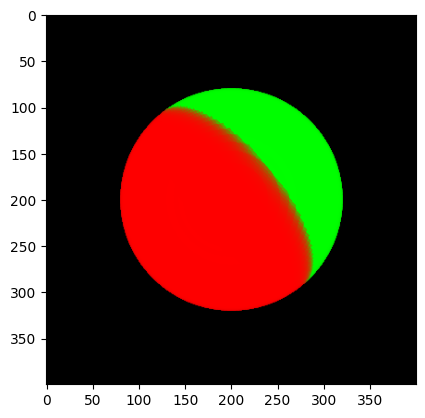

In [24]:
model = Sphere(torch.tensor([0., 0., 0.]), 1, torch.tensor([1., 0., 0.,]))
px_colors = rendering(model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 8, 12)

img = px_colors.reshape(H, W, 3)

plt.figure(dpi=100)
plt.imshow(img)

#### 3D Reconstruction Modules

##### EDA

In [25]:
data_path = './data/nerf/fox'
print(os.listdir(data_path))

print(os.listdir(data_path + '/imgs'))
# print(os.listdir(data_path + '/train'))

['imgs', 'test', 'train']
['test_0.png', 'test_1.png', 'test_2.png', 'test_3.png', 'test_4.png', 'test_5.png', 'test_6.png', 'test_7.png', 'test_8.png', 'test_9.png', 'train_0.png', 'train_1.png', 'train_10.png', 'train_11.png', 'train_12.png', 'train_13.png', 'train_14.png', 'train_15.png', 'train_16.png', 'train_17.png', 'train_18.png', 'train_19.png', 'train_2.png', 'train_20.png', 'train_21.png', 'train_22.png', 'train_23.png', 'train_24.png', 'train_25.png', 'train_26.png', 'train_27.png', 'train_28.png', 'train_29.png', 'train_3.png', 'train_30.png', 'train_31.png', 'train_32.png', 'train_33.png', 'train_34.png', 'train_35.png', 'train_36.png', 'train_37.png', 'train_38.png', 'train_39.png', 'train_4.png', 'train_40.png', 'train_41.png', 'train_42.png', 'train_43.png', 'train_44.png', 'train_45.png', 'train_46.png', 'train_47.png', 'train_48.png', 'train_49.png', 'train_5.png', 'train_50.png', 'train_51.png', 'train_52.png', 'train_53.png', 'train_54.png', 'train_55.png', 'train_

##### Camera / Dataset

In [26]:
def get_rays(data_path, split='train'):
    pose_file_names = os.listdir(data_path + f'/{split}/pose')
    intrinsics_file_names = os.listdir(data_path + f'/{split}/intrinsics') # parameters related to the camera
    img_filenames = [f for f in os.listdir(data_path + f'/imgs') if split in f]

    assert len(pose_file_names) == len(intrinsics_file_names), 'Files count mismatch.'
    assert len(pose_file_names) == len(img_filenames), 'Files count mismatch.'

    # Read the data
    N = len(pose_file_names)
    poses = np.zeros((N, 4, 4))
    intrinsics = np.zeros((N, 4, 4))
    images = []

    for i in range(N):
        name = pose_file_names[i]
        pose = open(data_path + f'/{split}/pose/' + name).read().split()
        poses[i] = np.array(pose, dtype=float).reshape(4,4)

        name = intrinsics_file_names[i]
        intrinsic = open(data_path + f'/{split}/intrinsics/' + name).read().split()
        intrinsics[i] = np.array(intrinsic, dtype=float).reshape(4,4)

        name = img_filenames[i]
        img = imageio.imread(data_path + f'/imgs/' + name) / 255.
        images.append(img[None,...])

    images = np.concatenate(images) # shape: (90, 400, 400, 4)
    
    H = images.shape[1]
    W = images.shape[2]

    # dropping the extra opacity channel
    if images.shape[-1] == 4:
        #RGBA -> RGB
        images = images[..., :3] * images[..., -1:] + (1 - images[..., -1:])

    # Creating rays, we have two components, each image pixel will have a ray, thus H*W, and 3 for 3D
    rays_o = np.zeros((N, H*W, 3)) # rays origin
    rays_d = np.zeros((N, H*W, 3)) # rays direction
    target_px_values = images.reshape((N, H*W, 3))

    # Iterate over each image
    for i in range(N):
        c2w = poses[i]
        f = intrinsics[i][0, 0]
        
        # Computing the coordinates of the pixels
        u = np.arange(W)
        v = np.arange(H)
        
        # Creating a grid with all possible pixel coord values
        # both u and v shapes will transform to H, W, this is because in image processing conventions, it’s always (H, W, …)
        u, v = np.meshgrid(u, v)
        
        # Computing the direction that is going from the image to the pinhole (center)
        # final shape will be (H, W, 3)
        # Single focal length
        dirs = np.stack(( u - W / 2,           # x-axis (horizontal shift from image center)
                         -(v - H / 2),         # y-axis (vertical shift, flipped so y points up)
                         -np.ones_like(u)*f    # z-axis (into the camera from the image)
                        ), axis=-1)            # stack along the last axis, thus stack all three on top of each other, and last axis will be 3
        # if we have different focal length values for x and y axises, we can divide by their values
        # dirs = np.stack(( (u - W / 2) / f_x, # x-axis (horizontal shift from image center)
        #          -(v - H / 2) / f_y,         # y-axis (vertical shift, flipped so y points up)
        #          -np.ones_like(u)            # z-axis (into the camera from the image)
        #         ), axis=-1)                  # stack along the last axis, thus stack all three on top of each other, and last axis will be 3

        
        # Convert from camera coordinate system to world coordinate system using the rotation matrix of the transformation matrix (3x3).
        dirs = (c2w[:3, :3] @ dirs[..., None])[..., 0]
        
        # rays_d.shape is (N, H, W, 3)
        dirs = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True) # normalize along the last axis dimension
        rays_d[i] = dirs.reshape(-1, 3) # reshape to (H*W, 3)
        
        # Adding the translation (last column) to the rays origin 
        rays_o[i] += c2w[:3, 3]

    return rays_o, rays_d, target_px_values

In [27]:
batch_size = 1024

o, d, target_px_values = get_rays(data_path, split='train')
dataloader = DataLoader(torch.cat((
    torch.from_numpy(o).reshape(-1, 3), # reshapes from (N, H*W, 3) to (N*H*W, 3)
    torch.from_numpy(d).reshape(-1, 3),
    torch.from_numpy(target_px_values).reshape(-1, 3)
), dim=1), batch_size=batch_size, shuffle=True)

test_o, test_d, test_target_px_values = get_rays(data_path, split='test')

/tmp/ipykernel_2146/2162220962.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(data_path + f'/imgs/' + name) / 255.


In [28]:
# [:, :3] > o
# [:, 3:6] > d
# [:, 6:] > targe
for i in dataloader:
    print(i.shape)
    print(i)
    break

torch.Size([1024, 9])
tensor([[-9.6140,  0.0938,  2.7500,  ...,  1.0000,  1.0000,  1.0000],
        [-7.6346,  3.6182,  5.3500,  ...,  0.6824,  0.5059,  0.3176],
        [ 4.4262, -8.7296,  2.0500,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [-4.2599, -8.8764,  1.7500,  ...,  1.0000,  1.0000,  1.0000],
        [-5.9047,  4.5729,  6.6500,  ...,  1.0000,  1.0000,  1.0000],
        [ 6.3140, -7.7182,  0.7500,  ...,  1.0000,  1.0000,  1.0000]],
       dtype=torch.float64)


In [29]:
test_target_px_values.shape

(10, 160000, 3)

Note that the rendering function in the previous sections will be used in the model training. The main difference is that rather than taking the mean of each bin, NeRF samples uniformally. This is called hierarchical sampling.

##### Model

In the NeRF paper, rather than having a single model, there are two NeRF models used. The first model will shoot rays and therefor will obtain a density curve for each time $t$. The second model will sample more rays where there are more density rather than sampling $t$ uniformally. This will also result in an update to the `rendering` function to take two models and number of bins parameters instead of one. The first model will sample uniformally and the second model will sample based on the density of the first model.

The below implementation will use a single model for simplicity. We will implement a 3D voxels model, each voxel will store the color and opacity (density), thus each voxel will store four values.

In [30]:
class Voxels(nn.Module):
    def __init__(self, nb_voxels=100, scale= 1, device='cpu'):
        super(Voxels, self).__init__()

        # to be able to optimize the params
        self.voxels = torch.nn.Parameter(
            torch.rand((nb_voxels, nb_voxels, nb_voxels, 4), device = device)) # four values, colors and desity, all positive.
        
        self.device = device
        self.scale = scale # the size of the 3D structure length for all of the voxels on that axis
        self.nb_voxels = nb_voxels
        
    def forward(self, xyz):
        ''' `xyz` shape: (N, 3) where each row is [x, y, z], where N is the batch size. '''
        x = xyz[:, 0] # shape (N,)
        y = xyz[:, 1] # shape (N,)
        z = xyz[:, 2] # shape (N,)

        # This is to make sure it is centerd, thus should be from -0.5 to 0.5 for each axis
        condition = (x.abs() < (self.scale / 2)) &\
                    (y.abs() < (self.scale / 2)) &\
                    (z.abs() < (self.scale / 2))

        # scale / nb_voxels is the side size of each voxel, adding (nb_voxels / 2) eliminates the -ve range of the values to be between 0-nb_voxels
        indx = (x[condition] / (self.scale / self.nb_voxels) + (self.nb_voxels / 2)).type(torch.long)
        indy = (y[condition] / (self.scale / self.nb_voxels) + (self.nb_voxels / 2)).type(torch.long)
        indz = (z[condition] / (self.scale / self.nb_voxels) + (self.nb_voxels / 2)).type(torch.long)
        
        colors_and_densities = torch.zeros((xyz.shape[0], 4), device=xyz.device)
        
        colors_and_densities[condition, :3] = self.voxels[indx, indy, indz, :3] # setting the colors
        colors_and_densities[condition, -1] = self.voxels[indx, indy, indz, -1] # setting the density

        return torch.sigmoid(colors_and_densities[:, :3]), torch.relu(colors_and_densities[:, -1])

    def intersect(self, x):
        return self.forward(x)

Note that for training, the created box of a series of voxels has to be large enough to include the shape we want to reconstruct, inside the box, at all possible positions, thus we can increase the `scale` factor, for example to 3.

In [31]:
model = Voxels(scale=1)

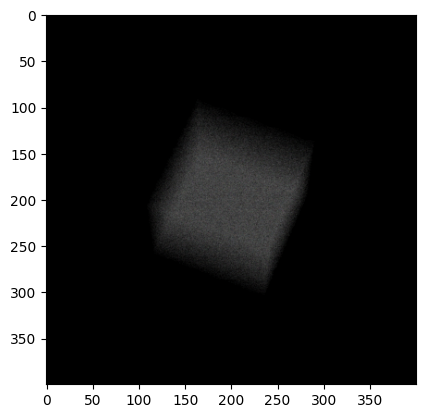

In [32]:
# Sending the rays for the first image
img = rendering(model, torch.from_numpy(o[-1]), torch.from_numpy(d[-1]), 8, 12)

plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())
plt.show()

In [33]:
trainable_params_names = [p[0] for p in model.named_parameters() if p[1].requires_grad]
trainable_params_count = sum(p[1].numel() for p in model.named_parameters() if p[1].requires_grad)
trainable_params_names, trainable_params_count

(['voxels'], 4000000)

##### Training

In [34]:
def training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device='cpu'):
    training_loss = []
    
    for epoch in range(nb_epochs):
        print(f"Epoch: {epoch+1}/{nb_epochs}")
        for batch in tqdm(dataloader):
            o = batch[:, :3].to(device)
            d = batch[:, 3:6].to(device)
            target = batch[:, 6:].to(device)

            prediction = rendering(model, o, d, tn, tf, nb_bins, device)
            loss = ((prediction - target)**2).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss.append(loss)
        
        scheduler.step()

    return training_loss

In [ ]:
device = 'cuda'
model = Voxels(scale=1, device=device)

lr = 1e-3
gamma = 0.5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma) # every 5 epochs multiply the lr by gamma

tn = 8
tf = 12
nb_bins = 100
nb_epochs = 15

training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device)

Epoch: 1/15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [01:41<00:00, 138.92it/s]


Epoch: 2/15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [01:33<00:00, 149.81it/s]


Epoch: 3/15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [01:39<00:00, 141.87it/s]


Epoch: 4/15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [01:40<00:00, 140.22it/s]


Epoch: 5/15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [01:39<00:00, 141.30it/s]


Epoch: 6/15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [01:55<00:00, 121.28it/s]


Epoch: 7/15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [01:36<00:00, 145.09it/s]


Epoch: 8/15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [01:55<00:00, 121.50it/s]


Epoch: 9/15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [01:31<00:00, 154.50it/s]


Epoch: 10/15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [01:25<00:00, 163.59it/s]


Epoch: 11/15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [01:30<00:00, 155.85it/s]


Epoch: 12/15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [01:34<00:00, 149.23it/s]


Epoch: 13/15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [01:27<00:00, 159.93it/s]


Epoch: 14/15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [01:26<00:00, 162.83it/s]


Epoch: 15/15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 14061/14063 [04:19<00:05,  2.97s/it]

In [ ]:
training_loss

In [ ]:
# plt.plot(training_loss)
# plt.show()

#### Notes

* Nerf-- (Without Camera Params) YT paper walkthrough: https://www.youtube.com/watch?v=Cf63bTpbt0s
* https://www.reddit.com/r/MachineLearning/comments/sm9li0/p_minimal_pytorch_implementation_of_nerf_full/
* https://docs.nerf.studio/nerfology/model_components/visualize_samples.html
* https://www.youtube.com/watch?v=CRlN-cYFxTk

#### Todos

* Siren vs NeRF?